# Mouse ESC-Endoderm example
The dataset for this example can be found from the [SCODE Github repo](https://github.com/hmatsu1226/SCODE). 

## Load packages

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE.jl/examples/mESC`


In [2]:
using NPZ
using NNlib
using OptimalTransport
using StatsBase
using SparseArrays
using LinearAlgebra
using Plots
using LaTeXStrings
using Graphs
using GraphSignals
using NearestNeighbors
using ProgressMeter
using Discretizers
import locaTE as lTE;
using Suppressor
using CSV, DataFrames
using Printf
pyplot()

Plots.PyPlotBackend()

## Load files
Load dataset and reference

In [3]:
DATA_DIR = "data"
X = relu.(npzread(joinpath(DATA_DIR, "X.npy")) .- 1e-2)
X_pca = npzread(joinpath(DATA_DIR, "X_pca.npy"))
P = npzread(joinpath(DATA_DIR, "P_statot.npy"))
C = npzread(joinpath(DATA_DIR, "C.npy"))
dpt = npzread(joinpath(DATA_DIR, "dpt.npy"));
J = npzread(joinpath(DATA_DIR, "J.npy"));
J[diagind(J)] .= 0;
J_escape = npzread(joinpath(DATA_DIR, "J_ESCAPE.npy"));
J_escape[diagind(J_escape)] .= 0;
try
    global genes = Array(CSV.read(joinpath(DATA_DIR, "genes.txt"), DataFrame)[:, 2])
catch e
    @info "Exception: $e"
    global genes = ["gene_$i" for i = 1:size(X, 2)]
end;

## Construct sparse forward and backward transition matrices for `k` steps of `P`.

In [4]:
# Construct neighbourhood kernel using QOT 
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5 * mean(C));
# Write neighbourhood kernel to disk (for use with locaTE-cmd tool)
npzwrite(joinpath(DATA_DIR, "R.npy"), R)

In [5]:
k = 1
Q = lTE.to_backward_kernel(P)
P_sp = sparse((P^k))
QT_sp = sparse((Q^k)')
R_sp = sparse(R);

## Visualise coupling 

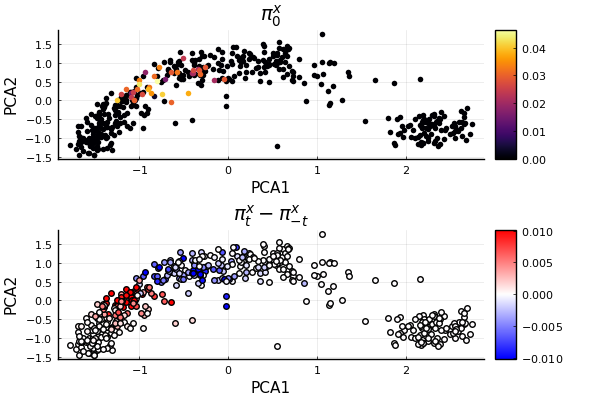

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [6]:
p0 = R[sortperm(dpt)[250], :]
plt = plot(
    scatter(
        X_pca[sortperm(p0), 1],
        X_pca[sortperm(p0), 2];
        marker_z = sort(p0),
        markerstrokewidth = 0,
        alpha = 1.0,
        xlabel = "PCA1",
        ylabel = "PCA2",
        title = L"π_0^x",
    ),
    scatter(
        X_pca[:, 1],
        X_pca[:, 2];
        marker_z = P_sp' * p0 - QT_sp * p0,
        color = :bwr,
        clim = (-0.0101, 0.0101),
        alpha = 1.0,
        xlabel = "PCA1",
        ylabel = "PCA2",
        title = L"\pi^x_{t} - \pi^x_{-t}",
    );
    legend = nothing,
    layout = (2, 1),
)
plt

Construct kNN graph and normalized Laplacian for later use

In [7]:
L = lTE.construct_normalized_laplacian(X_pca, 25);

## Estimate TE scores

In [8]:
TE = lTE.estimate_TE(
    X,
    1:size(X, 2),
    1:size(X, 2),
    P_sp,
    QT_sp,
    R_sp,
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


In [9]:
# estimate TE with GPU acceleration
# TE_cu = lTE.estimate_TE_cu(
#     X,
#     1:size(X, 2),
#     1:size(X, 2),
#     Array(P_sp),
#     Array(QT_sp),
#     Array(R_sp),
# );

## Filter raw TE scores using wCLR 

In [10]:
TE_clr = lTE.apply_wclr(TE, size(X, 2), size(X, 2))
TE_clr[isnan.(TE_clr)] .= 0;

## Denoise using graph-regularized regression

In [11]:
w = vec(sqrt.(sum(TE_clr .^ 2; dims = 2)))
w /= sum(w)
G = lTE.fitsp(TE_clr, L; λ1 = 10.0, λ2 = 0.001, maxiter = 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56
[ Info: ΔX = 8.714946145362983e-7, ΔZ = 0.0001324569788215095, ΔW = 0.00014657782670346106
[ Info: tr(X'LX) = 5.39481035529971, 0.5|X-G|^2 = 8.625890946554039, |X|1 = 10708.79212175212


To get a static network, aggregate over pseudotime, and then CDF normalise

In [12]:
G_static = reshape(mean(G; dims = 1), size(X, 2), size(X, 2));
G_static_cdf = lTE.cdf_norm(G_static, G_static .+ 1e-9);
A = reshape(maximum(G; dims = 1), size(X, 2), size(X, 2));
G_cdf = lTE.apply_cdf_norm(G, A .+ 1e-9);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


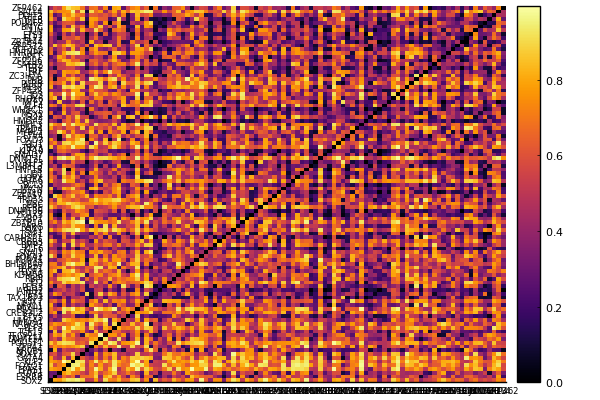

In [13]:
heatmap(
    G_static_cdf,
    xticks = (collect(1:length(genes)), genes),
    yticks = (collect(1:length(genes)), genes),
    xrotation = 45,
    xtickfontsize = 6,
    ytickfontsize = 6,
)

Rank genes by the total outgoing TE score

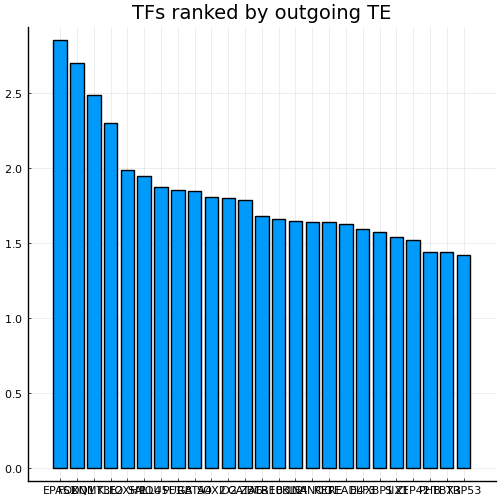

In [14]:
total_TE = vec(sum(reshape(maximum(G; dims = 1), size(X, 2), size(X, 2)); dims = 2))
topk = 25 # show top 25 genes
bar(
    1:topk,
    sort(total_TE; rev = true)[1:topk];
    xticks = (1:topk, genes[sortperm(total_TE; rev = true)][1:topk]),
    xrotation = 45,
    legend = nothing, 
    title = "TFs ranked by outgoing TE",
    size = (500, 500),
)

Do the same, this time using the ESCAPE gold standard

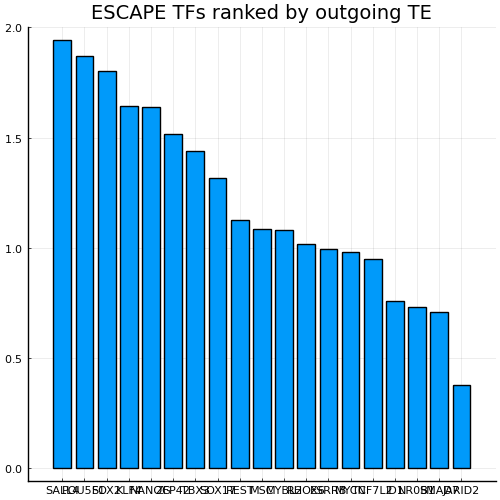

In [15]:
regulators = vec(sum(J_escape; dims = 2) .> 0)
bar(
    1:sum(regulators),
    sort(total_TE[regulators]; rev = true);
    xticks = (
        1:sum(regulators),
        genes[regulators][sortperm(total_TE[regulators]; rev = true)],
    ),
    legend = nothing, 
    title = "ESCAPE TFs ranked by outgoing TE",
    xrotation = 45,
    size = (500, 500),
)

## Investigate NANOG → ELF3 interaction

[ Info: ("Reference for NANOG → ELF3:", 1.0)


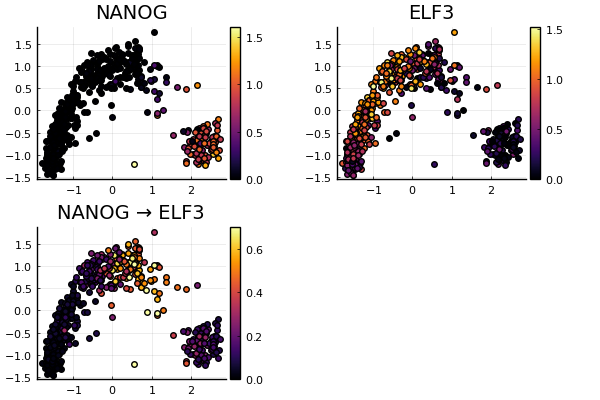

In [16]:
g1 = "NANOG"
g2 = "ELF3"
@info "Reference for $g1 → $g2:", first(J_escape[genes.==g1, :][:, genes.==g2])
plot(
    scatter(
        X_pca[:, 1],
        X_pca[:, 2],
        marker_z = X[:, findfirst(x -> x == g1, genes)],
        title = g1,
    ),
    scatter(
        X_pca[:, 1],
        X_pca[:, 2],
        marker_z = X[:, findfirst(x -> x == g2, genes)],
        title = g2,
    ),
    scatter(
        X_pca[:, 1],
        X_pca[:, 2],
        marker_z = reshape(G_cdf, :, size(X, 2), size(X, 2))[
            :,
            findfirst(x -> x == g1, genes),
            findfirst(x -> x == g2, genes),
        ],
        title = "$(g1) → $(g2)",
        clim = (0, quantile(vec(G_cdf[G_cdf.>0]), 0.99)),
    );
    legend = nothing,
)

## ROC and PR curves using ESCAPE reference

┌ Warning: The closest higher feasible true positive rate to some of the required values (0.9966555183946488) is 1.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:93


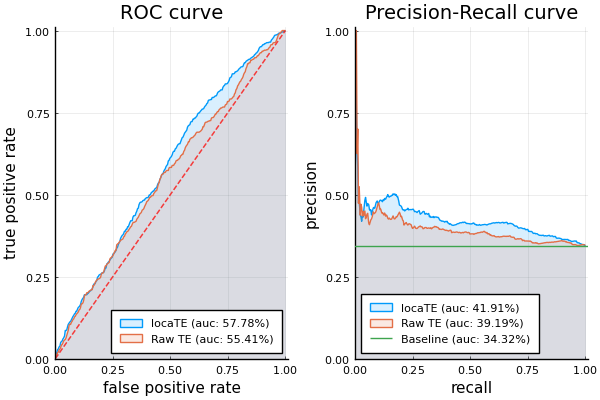

In [17]:
using EvalMetrics
plt1 = rocplot(
    vec(J_escape[regulators, :]),
    vec(G_static_cdf[regulators, :]);
    label = "locaTE",
)
rocplot!(
    vec(J_escape[regulators, :]),
    vec(reshape(mean(TE; dims = 1), size(X, 2), size(X, 2))[regulators, :]);
    label = "Raw TE",
)
plt2 = prplot(
    vec(J_escape[regulators, :]),
    vec(G_static[regulators, :]);
    label = "locaTE",
)
prplot!(
    vec(J_escape[regulators, :]),
    vec(reshape(mean(TE; dims = 1), size(X, 2), size(X, 2))[regulators, :]);
    label = "Raw TE",
)
hline!(
    plt2,
    [mean(J_escape[regulators, :] .> 0)];
    label = @sprintf("Baseline (auc: %0.2f%%)", 100 * mean(J_escape[regulators, :] .> 0)),
)
plot(plt1, plt2)

## Factor analysis with NMF

In [18]:
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X) .^ 2;
Cg[diagind(Cg)] .= 0;
U, V, trace = lTE.fitnmf(
    relu.(qnorm(TE_clr, 0.9)),
    [I(size(G, 1)), I(size(G, 2))],
    1e-3 * I + L,
    repeat(vec(Cg), 1, size(X, 1))',
    8;
    α = 10.0,
    β = 0.0,
    λ = [1.0, 1.0],
    μ = [1.0, 1.0],
    iter = 250,
    initialize = :nmf,
    print_iter = 50,
    dictionary = false,
    η = 1.0,
);
G_nmf = Array(U * V');
U = Array(U);
V = Array(V);
# Rescale U, V
U .*= mean(V; dims = 1)
V ./= mean(V; dims = 1);

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


Plot coefficients

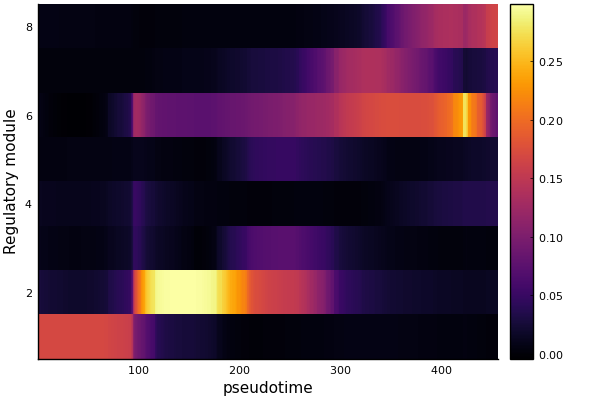

In [19]:
using PyCall
pygam = pyimport_conda("pygam", "pygam")
#r fit a GAM for each set of coefficients
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(dpt, u) for u in eachcol(U)]
U_gam = hcat([g.predict(dpt) for g in coeff_gam]...)
perm = sortperm(vec(sum((U ./ sum(U; dims = 1)) .* dpt; dims = 1)))
heatmap(
    U_gam[sortperm(dpt), perm]',
    xlabel = "pseudotime",
    ylabel = "Regulatory module",
)